In [60]:
import sqlalchemy as sa 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import calendar

In [58]:
# Create and connect to engine 
engine = sa.create_engine("sqlite:///../power_outages.db")
connection = engine.connect()

# Create Resolve Time column 
q = sa.text("""SELECT * FROM POWER_OUTAGES""")

# Read to pandas dataframe 
df = pd.read_sql(q, connection)

# Close connection to database 
connection.close()
engine.dispose() 

# Format columns 
df['created_date'] = pd.to_datetime(df['created_date'], utc=False)
df['closed_date'] = pd.to_datetime(df['closed_date'], utc=False)
df['resolution_action_updated_date'] = pd.to_datetime(df['resolution_action_updated_date'], utc=False)
df['resolve_time_hours'] = (df['closed_date'] - df['created_date']).dt.total_seconds() / 3600
df['resolve_time_hours'] = np.floor(pd.to_numeric(df['resolve_time_hours'], errors='coerce')).astype('Int64')
df['incident_zip'] = df['incident_zip'].astype('Int64') 
df["incident_address"] = (df["incident_address"].str.replace(r"\s+", " ", regex=True))

# Filter duplicates and null geospatial values 
df = df[~df.resolution_description.str.contains('duplicate',na=False)] #  > 2000 rows
df = df[~df['latitude'].isnull()] # 2 rows containing duplicates 
df = df[~df['longitude'].isnull()] # 2 rows


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39753 entries, 0 to 41846
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   unique_key                      39753 non-null  int64         
 1   created_date                    39753 non-null  datetime64[ns]
 2   closed_date                     39373 non-null  datetime64[ns]
 3   descriptor_2                    39753 non-null  object        
 4   incident_zip                    39753 non-null  Int64         
 5   incident_address                39753 non-null  object        
 6   street_name                     39753 non-null  object        
 7   city                            39753 non-null  object        
 8   status                          39753 non-null  object        
 9   resolution_description          39553 non-null  object        
 10  resolution_action_updated_date  39732 non-null  datetime64[ns]
 11  communi

In [71]:
def plot_month_distribution(full_df, years=None):
    """
    Creates a grouped bar plot showing monthly distribution across multiple years.
    
    Parameters:
    -----------
    full_df : DataFrame
    years : List of years.If None, uses all years in the data.
    """

    
    try:
        # Filter years if specified
        df = full_df.copy()
        if years is not None:
            df = df[df["created_date"].dt.year.isin(years)]
        
        # Extract year and month
        df["year"] = df["created_date"].dt.year
        df["month"] = df["created_date"].dt.month
        
        # Create the plot - seaborn handles the grouping automatically
        plt.figure(figsize=(12, 6))
        ax = sns.countplot(data=df, x="month", hue="year", palette="bright")
        
        # Set x-axis labels to month abbreviations
        ax.set_xticks(range(12))
        ax.set_xticklabels(calendar.month_abbr[1:], rotation=0)
        
        plt.title("Power Outage Distribution by Month and Year")
        plt.xlabel("Month")
        plt.ylabel("Count")
        plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
    except ValueError as e:
        print("Error in plotting:", e)

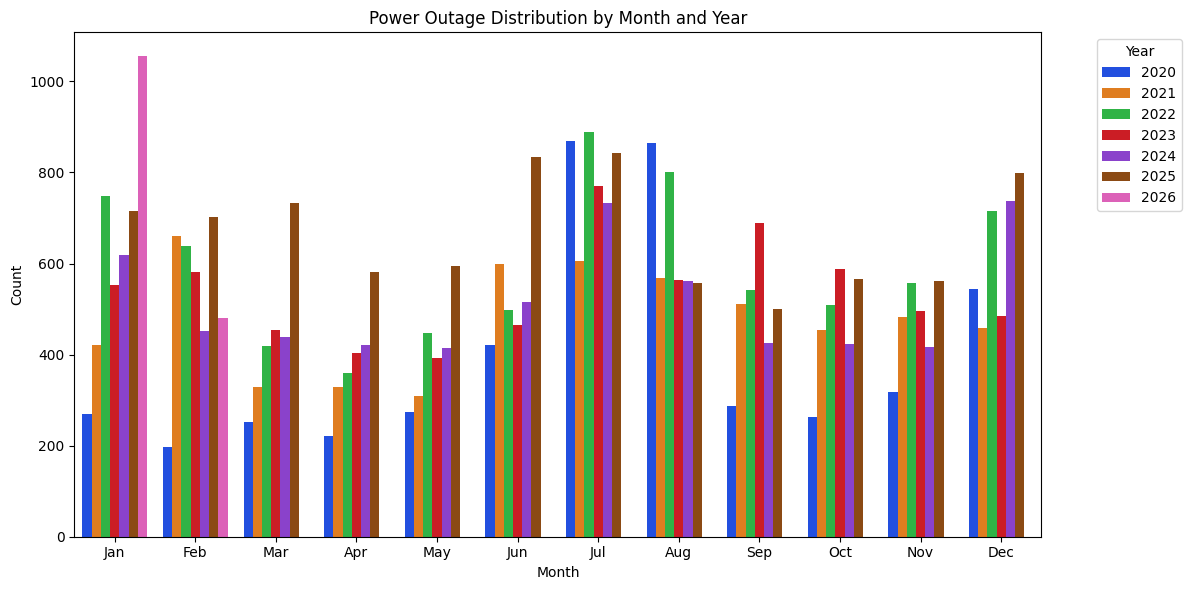

In [72]:
plot_month_distribution(df)

As expected, the summer and winter months have the most power outages for each year. The distribution for February 2026 is incomplete but it had the highest power outage complaints compared to other years.